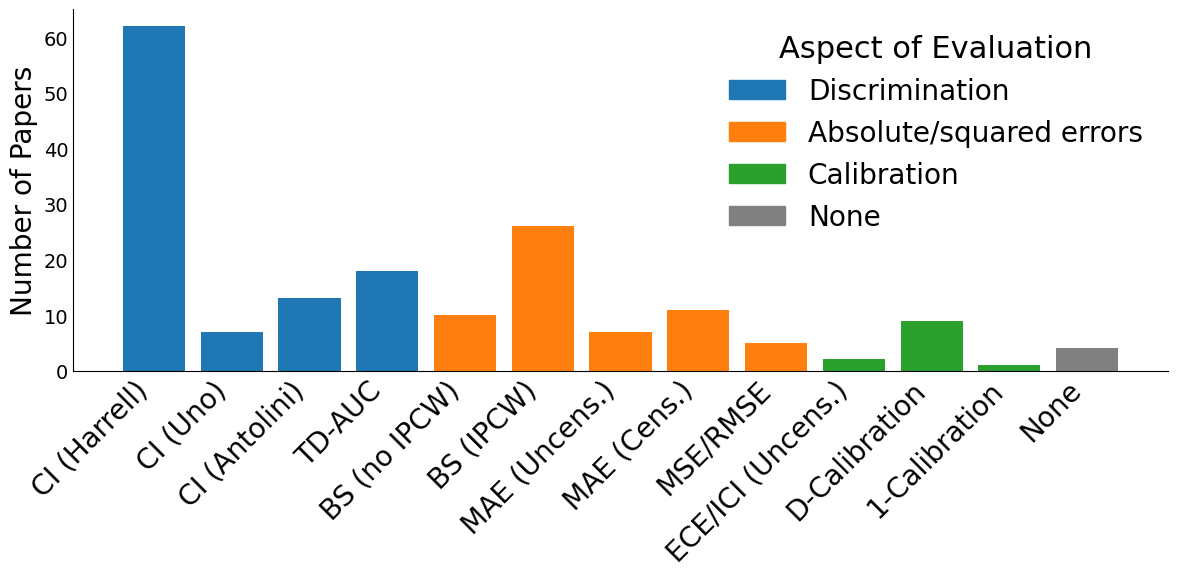

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import re

matplotlib_style = 'default'
plt.style.use(matplotlib_style)
plt.rcParams.update({
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'large',
    'font.size': 14.0,
    'legend.fontsize': 'x-large',
    'xtick.labelsize': 'x-large',
})

# Load data
df = pd.read_csv('data/metrics_used.csv')

# normalize column names (strip whitespace)
df.columns = [c.strip() for c in df.columns]

# rename CSV headers to match category labels
rename_map = {
    "IBS": "BS (IPCW)",
    "BS": "BS (no IPCW)",          # <- NEW (if present in CSV)
    "MAE (Uncens)": "MAE (Uncens.)",
    "ECE/ICI": "ECE/ICI (Uncens.)",
    "D-Calib": "D-Calibration",
    "1-Calib": "1-Calibration",
}
df = df.rename(columns=rename_map)

# Ensure "None" column exists (rightmost)
if "None" not in df.columns:
    df["None"] = pd.NA

# Move "None" to the end
df = df[[c for c in df.columns if c != "None"] + ["None"]]

# Count non-empty values per metric (excluding title column)
metric_cols = df.columns[1:]
metric_counts = df.loc[:, metric_cols].apply(
    lambda col: col.notna() & (col != ''),
    axis=0
).sum()

# Create combined censored MAE metric
mae_cens_sum = (
    metric_counts.get("MAE (Hinge)", 0)
    + metric_counts.get("MAE (Margin)", 0)
    + metric_counts.get("MAE (PO)", 0)
)
metric_counts = metric_counts.drop(
    ["MAE (Hinge)", "MAE (Margin)", "MAE (PO)"],
    errors="ignore"
)
metric_counts["MAE (Cens.)"] = mae_cens_sum

# Metric categories
categories = {
    "Discrimination": [
        "CI (Harrell)", "CI (Uno)", "CI (Antolini)", "TD-AUC"
    ],
    "Absolute/squared errors": [
        "BS (no IPCW)",
        "BS (IPCW)",
        "MAE (Uncens.)",
        "MAE (Cens.)",
        "MSE/RMSE"
    ],
    "Calibration": [
        "ECE/ICI (Uncens.)",
        "D-Calibration",
        "1-Calibration"
    ],
}

category_colors = {
    "Discrimination": "tab:blue",
    "Absolute/squared errors": "tab:orange",
    "Calibration": "tab:green"
}

metric_to_category = {
    m: cat for cat, ms in categories.items() for m in ms
}
metric_to_color = {
    m: category_colors[metric_to_category[m]]
    for m in metric_counts.index
    if m in metric_to_category
}

# Build plotting order
sorted_metrics = sum(categories.values(), [])
if "None" not in sorted_metrics:
    sorted_metrics.append("None")

# Make None grey
metric_to_color["None"] = "grey"

plt.figure(figsize=(12, 6))
plt.bar(
    sorted_metrics,
    [metric_counts.get(m, 0) for m in sorted_metrics],
    color=[metric_to_color.get(m, "gray") for m in sorted_metrics],
)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

legend_handles = [
    Patch(color=color, label=cat)
    for cat, color in category_colors.items()
]
legend_handles.append(Patch(color="grey", label="None"))

leg = plt.legend(
    handles=legend_handles,
    title="Aspect of Evaluation",
    frameon=False
)
leg.get_title().set_fontsize(22)

plt.ylabel("Number of Papers")
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0)

plt.tight_layout()
plt.savefig("plots/metrics_used.pdf", format="pdf", bbox_inches="tight")
plt.show()

<Figure size 1000x700 with 0 Axes>

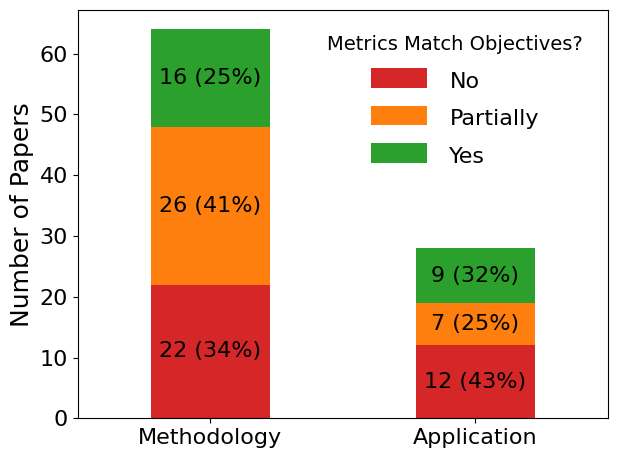

In [3]:
# Load the file
df = pd.read_csv("data/correct_evaluation.csv")

# Remove completely empty rows
df = df.dropna(how="all")

# Select and clean relevant columns
df_eval = df.loc[:, ["Problem type", "Metrics Match Objectives?"]].dropna()

# Normalize
df_eval["Metrics Match Objectives?"] = (
    df_eval["Metrics Match Objectives?"]
    .astype(str)
    .str.strip()
    .str.split(",", n=1).str[0]
    .str.replace(r"[^\w\s-]", "", regex=True)
    .str.strip()
    .str.capitalize()
)

df_eval.loc[:, "Problem type"] = df_eval["Problem type"].str.strip()

# Count combinations
counts = (
    df_eval.groupby(["Problem type", "Metrics Match Objectives?"])
    .size()
    .unstack(fill_value=0)
)

# Ensure ordering
counts = counts.reindex(["Methodology", "Application"])

# Compute percentages
pct = counts.div(counts.sum(axis=1), axis=0) * 100

# Plot
plt.figure(figsize=(10,7))
ax = counts.plot(
    kind="bar",
    stacked=True,
    color={"Yes": "tab:green", "No": "tab:red", "Partially": "tab:orange"},
    fontsize=16
)
leg = ax.legend(
    title="Metrics Match Objectives?",
    frameon=False
)
plt.setp(leg.get_texts(), fontsize=16)      # legend entries
leg.get_title().set_fontsize(14)             # legend title

desired_width = 0.45  # make bars narrow
for bar in ax.patches:
    current_width = bar.get_width()
    diff = current_width - desired_width

    # Shrink bar & shift it so it's still centered:
    bar.set_width(desired_width)
    bar.set_x(bar.get_x() + diff / 2)

# Labels
plt.ylabel("Number of Papers", fontsize=18)
plt.xlabel("", fontsize=18)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)

for i, (ptype, row) in enumerate(counts.iterrows()):
    cumulative = 0
    for outcome in ["No", "Partially", "Yes"]:
        value = row.get(outcome, 0)
        percent = pct.loc[ptype, outcome]
        if value > 0:
            label = f"{value} ({percent:.0f}%)"
            ax.text(
                i,
                cumulative + value/2,
                label,
                ha="center",
                va="center",
                fontsize=16,
                color="black"
            )
        cumulative += value

plt.tight_layout()
plt.savefig("plots/metrics_correctness.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [4]:
# Sanity check
import pandas as pd
import re

def normalize_paper_id(s: pd.Series) -> pd.Series:
    # robust normalization: string, strip, collapse whitespace, lowercase
    s = s.astype(str)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip().str.lower()
    return s

# Load both files
df_metrics = pd.read_csv("data/metrics_used.csv")
df_correct = pd.read_csv("data/correct_evaluation.csv")

key = "Title"

# Basic checks
if key not in df_metrics.columns:
    raise KeyError(f"'{key}' not found in metrics_used.csv. Columns: {list(df_metrics.columns)}")
if key not in df_correct.columns:
    raise KeyError(f"'{key}' not found in correct_evaluation.csv. Columns: {list(df_correct.columns)}")

# Normalize IDs
ids_metrics = normalize_paper_id(df_metrics[key])
ids_correct = normalize_paper_id(df_correct[key])

# Count totals + uniques
print("=== Counts ===")
print(f"metrics_used.csv rows:      {len(df_metrics)}  | unique papers: {ids_metrics.nunique()}")
print(f"correct_evaluation.csv rows:{len(df_correct)}  | unique papers: {ids_correct.nunique()}")

# Compare sets
set_metrics = set(ids_metrics)
set_correct = set(ids_correct)

only_in_metrics = sorted(set_metrics - set_correct)
only_in_correct = sorted(set_correct - set_metrics)

print("\n=== Set comparison (after normalization) ===")
print(f"Only in metrics_used.csv:       {len(only_in_metrics)}")
print(f"Only in correct_evaluation.csv: {len(only_in_correct)}")

# Show a few examples if mismatched
if only_in_metrics:
    print("\nExamples only in metrics_used.csv:")
    for x in only_in_metrics[:20]:
        print("  -", x)

if only_in_correct:
    print("\nExamples only in correct_evaluation.csv:")
    for x in only_in_correct[:20]:
        print("  -", x)

# Duplicate detection (often the real issue)
dupes_metrics = ids_metrics[ids_metrics.duplicated(keep=False)].value_counts()
dupes_correct = ids_correct[ids_correct.duplicated(keep=False)].value_counts()

print("\n=== Duplicates (normalized) ===")
print(f"Duplicates in metrics_used.csv: {int((ids_metrics.duplicated()).sum())}")
if not dupes_metrics.empty:
    print(dupes_metrics.head(20))

print(f"\nDuplicates in correct_evaluation.csv: {int((ids_correct.duplicated()).sum())}")
if not dupes_correct.empty:
    print(dupes_correct.head(20))

=== Counts ===
metrics_used.csv rows:      92  | unique papers: 92
correct_evaluation.csv rows:107  | unique papers: 93

=== Set comparison (after normalization) ===
Only in metrics_used.csv:       0
Only in correct_evaluation.csv: 1

Examples only in correct_evaluation.csv:
  - nan

=== Duplicates (normalized) ===
Duplicates in metrics_used.csv: 0

Duplicates in correct_evaluation.csv: 14
nan    15
Name: Title, dtype: int64


In [5]:
import pandas as pd

df = pd.read_csv("data/metrics_used.csv")

key = "Title"

# Clean paper IDs
df[key] = (
    df[key]
    .astype(str)
    .str.strip()
    .replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA})
)

# Drop invalid + deduplicate papers
df = df.dropna(subset=[key])
df = df.drop_duplicates(subset=[key])

# Helper: metric used if non-empty (e.g., "X")
def is_used(s):
    return s.notna() & (s.astype(str).str.strip() != "")

counts = {}

# Direct metrics (matching your CSV)
direct_metrics = [
    "CI (Harrell)",
    "CI (Uno)",
    "CI (Antolini)",
    "TD-AUC",
    "BS (no IPCW)",
    "BS (IPCW)",
    "MAE (Uncens)",
    "MSE/RMSE",
    "ECE/ICI",
    "D-Calib",
    "1-Calib",
]

for m in direct_metrics:
    if m in df.columns:
        counts[m] = is_used(df[m]).sum()
    else:
        counts[m] = 0
        print(f"WARNING: Column not found: {m}")

# Aggregated censored MAE (any of these)
mae_cens_cols = [
    "MAE (Hinge)",
    "MAE (Margin)",
    "MAE (PO)",
]

present_mae_cens_cols = [c for c in mae_cens_cols if c in df.columns]

if present_mae_cens_cols:
    mae_cens_used = df[present_mae_cens_cols].apply(is_used).any(axis=1)
    counts["MAE (Cens.)"] = mae_cens_used.sum()
else:
    counts["MAE (Cens.)"] = 0
    print("WARNING: No censored MAE columns found")

total_papers = len(df)

print(f"\nTotal unique papers: {total_papers}\n")

# Print in your requested order
print(f"{'CI (Harrell)':20s}: {counts['CI (Harrell)']:3d} / {total_papers}")
print(f"{'CI (Uno)':20s}: {counts['CI (Uno)']:3d} / {total_papers}")
print(f"{'CI (Antolini)':20s}: {counts['CI (Antolini)']:3d} / {total_papers}")
print(f"{'TD-AUC':20s}: {counts['TD-AUC']:3d} / {total_papers}")
print(f"{'BS (no IPCW)':20s}: {counts['BS (no IPCW)']:3d} / {total_papers}")
print(f"{'BS (IPCW)':20s}: {counts['BS (IPCW)']:3d} / {total_papers}")
print(f"{'MAE (Uncens.)':20s}: {counts['MAE (Uncens)']:3d} / {total_papers}")
print(f"{'MAE (Cens.)':20s}: {counts['MAE (Cens.)']:3d} / {total_papers}")
print(f"{'MSE/RMSE':20s}: {counts['MSE/RMSE']:3d} / {total_papers}")
print(f"{'ECE/ICI':20s}: {counts['ECE/ICI']:3d} / {total_papers}")
print(f"{'D-Calibration':20s}: {counts['D-Calib']:3d} / {total_papers}")
print(f"{'1-Calibration':20s}: {counts['1-Calib']:3d} / {total_papers}")


Total unique papers: 92

CI (Harrell)        :  62 / 92
CI (Uno)            :   7 / 92
CI (Antolini)       :  13 / 92
TD-AUC              :  18 / 92
BS (no IPCW)        :  10 / 92
BS (IPCW)           :  26 / 92
MAE (Uncens.)       :   7 / 92
MAE (Cens.)         :   9 / 92
MSE/RMSE            :   5 / 92
ECE/ICI             :   2 / 92
D-Calibration       :   9 / 92
1-Calibration       :   1 / 92


In [6]:
import re
import pandas as pd
from pathlib import Path

# Helpers
def norm_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s).strip().lower()
    s = re.sub(r"\s+", " ", s)
    s = s.replace("–", "-").replace("—", "-")
    s = s.replace("{", "").replace("}", "")
    s = re.sub(r"[^\w\s\-]", "", s)
    return s

def parse_bib_titles(bib_text: str) -> dict:
    entries = re.split(r"\n(?=@)", bib_text, flags=re.MULTILINE)
    title_to_key = {}

    for e in entries:
        e = e.strip()
        if not e.startswith("@"):
            continue

        m_key = re.search(r"@\w+\s*{\s*([^,\s]+)\s*,", e)
        if not m_key:
            continue
        key = m_key.group(1).strip()

        m_title = re.search(
            r"\btitle\s*=\s*(\{(?:[^{}]|\{[^{}]*\})*\}|\"(?:\\.|[^\"])*\")\s*,?",
            e,
            flags=re.IGNORECASE | re.DOTALL
        )
        if not m_title:
            continue

        raw_title = m_title.group(1).strip()
        if raw_title.startswith("{") and raw_title.endswith("}"):
            raw_title = raw_title[1:-1]
        elif raw_title.startswith('"') and raw_title.endswith('"'):
            raw_title = raw_title[1:-1]

        nt = norm_text(raw_title)
        if nt:
            title_to_key.setdefault(nt, key)

    return title_to_key

def is_used(series: pd.Series) -> pd.Series:
    return series.notna() & (series.astype(str).str.strip() != "")

# Load data
df = pd.read_csv("data/metrics_used.csv")

key_col = "Title"
df.columns = [c.strip() for c in df.columns]

df[key_col] = (
    df[key_col]
    .astype(str)
    .str.strip()
    .replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA})
)
df = df.dropna(subset=[key_col]).drop_duplicates(subset=[key_col])

total_papers = len(df)

# Build title -> bibkey map
bib_text = Path("data/references.bib").read_text(encoding="utf-8")
bib_title_to_key = parse_bib_titles(bib_text)

paper_to_bibkey = {}
for title in df[key_col].tolist():
    paper_to_bibkey[title] = bib_title_to_key.get(norm_text(title), None)

# Metric definitions
metric_specs = [
    ("CI (Harrell)", ["CI (Harrell)"], False),
    ("CI (Uno)", ["CI (Uno)"], False),
    ("CI (Antolini)", ["CI (Antolini)"], False),
    ("TD-AUC", ["TD-AUC"], False),
    ("BS (no IPCW)", ["BS (no IPCW)"], False),
    ("BS (IPCW)", ["BS (IPCW)"], False),
    ("MAE (Uncens.)", ["MAE (Uncens)"], False),
    ("MAE (Cens.)", ["MAE (Hinge)", "MAE (Margin)", "MAE (PO)"], True),
    ("MSE/RMSE", ["MSE/RMSE"], False),
    ("ECE/ICI (Uncens.)", ["ECE/ICI"], False),
    ("D-Calibration", ["D-Calib"], False),
    ("1-Calibration", ["1-Calib"], False),
    ("None", ["None"], False),
]

# Compute rows
rows = []
for row_label, cols, any_agg in metric_specs:
    present_cols = [c for c in cols if c in df.columns]

    if not present_cols:
        used_mask = pd.Series(False, index=df.index)
    else:
        used_flags = df[present_cols].apply(is_used)
        used_mask = used_flags.any(axis=1) if any_agg else used_flags[present_cols[0]]

    count = int(used_mask.sum())
    pct = (count / total_papers * 100.0) if total_papers else 0.0

    used_titles = df.loc[used_mask, key_col].tolist()
    cite_keys = []
    for t in used_titles:
        k = paper_to_bibkey.get(t)
        if k:
            cite_keys.append(k)

    # de-duplicate keys
    seen = set()
    cite_keys = [k for k in cite_keys if not (k in seen or seen.add(k))]

    rows.append({
        "metric": row_label,
        "count": count,
        "pct": pct,
        "cite_keys": cite_keys
    })

# Emit LaTeX longtable
caption = f"Metrics used in survival analysis papers (2023-2025). Total number of included articles: {total_papers}."
label = "tab:evaluation_metrics_survey"

lines = []
lines.append(r"\begin{longtable}{@{}p{2.7cm}p{3.4cm}p{8.1cm}@{}}")
lines.append(rf"\caption{{{caption}}}")
lines.append(rf"\label{{{label}}}")
lines.append(r"\\")
lines.append(r"\toprule")
lines.append(r"\multicolumn{1}{p{2.7cm}}{Evaluation Metric} &")
lines.append(r"\multicolumn{1}{p{3.4cm}}{Number of Papers (\%)} &")
lines.append(r"\multicolumn{1}{p{8.1cm}}{Reference} \\")
lines.append(r"\midrule")
lines.append(r"\endfirsthead")
lines.append("")
lines.append(r"\toprule")
lines.append(r"\multicolumn{1}{p{2.7cm}}{Evaluation Metric} &")
lines.append(r"\multicolumn{1}{p{3.4cm}}{Number of Papers (\%)} &")
lines.append(r"\multicolumn{1}{p{8.1cm}}{Reference} \\")
lines.append(r"\midrule")
lines.append(r"\endhead")
lines.append("")
lines.append(r"\bottomrule")
lines.append(r"\endfoot")
lines.append("")

for r in rows:
    count = r["count"]
    pct_1dp = round(r["pct"], 1)
    cite = ",".join(r["cite_keys"])

    lines.append(rf"{r['metric']} & {count} ({pct_1dp}\%) &")
    lines.append(rf"\citep{{{cite}}} \\")
    lines.append("")

lines.append(r"\end{longtable}")
latex_table = "\n".join(lines)

out_path = Path("tables/evaluation_metrics_survey.tex")
out_path.parent.mkdir(parents=True, exist_ok=True)
out_path.write_text(latex_table, encoding="utf-8")

print(f"Wrote: {out_path}")

# Report unmatched titles
unmatched = [t for t, k in paper_to_bibkey.items() if k is None]
print(f"\nUnmatched papers (no bib key found): {len(unmatched)}")
for t in unmatched[:20]:
    print(" -", t)

Wrote: tables\evaluation_metrics_survey.tex

Unmatched papers (no bib key found): 0


In [7]:
import re
import pandas as pd
from pathlib import Path

# Helpers
def capitalize_first(s: str) -> str:
    """Capitalize only the first character, keep rest unchanged."""
    if not s:
        return s
    return s[0].upper() + s[1:]

def norm_text(s: str) -> str:
    """Normalize titles for matching (robust to whitespace/case/punctuation/braces)."""
    if s is None:
        return ""
    s = str(s).strip().lower()
    s = re.sub(r"\s+", " ", s)
    s = s.replace("–", "-").replace("—", "-")
    s = s.replace("{", "").replace("}", "")
    s = re.sub(r"[^\w\s\-]", "", s)  # keep words/spaces/hyphen
    return s

def parse_bib_titles(bib_text: str) -> dict:
    """
    Return dict: normalized_title -> citation_key
    Handles title = {...} or title = "..."
    """
    entries = re.split(r"\n(?=@)", bib_text, flags=re.MULTILINE)
    title_to_key = {}

    for e in entries:
        e = e.strip()
        if not e.startswith("@"):
            continue

        m_key = re.search(r"@\w+\s*{\s*([^,\s]+)\s*,", e)
        if not m_key:
            continue
        key = m_key.group(1).strip()

        # title field (supports nested braces shallowly enough for most .bib titles)
        m_title = re.search(
            r"\btitle\s*=\s*(\{(?:[^{}]|\{[^{}]*\})*\}|\"(?:\\.|[^\"])*\")\s*,?",
            e,
            flags=re.IGNORECASE | re.DOTALL
        )
        if not m_title:
            continue

        raw_title = m_title.group(1).strip()
        if raw_title.startswith("{") and raw_title.endswith("}"):
            raw_title = raw_title[1:-1]
        elif raw_title.startswith('"') and raw_title.endswith('"'):
            raw_title = raw_title[1:-1]

        nt = norm_text(raw_title)
        if nt:
            title_to_key.setdefault(nt, key)

    return title_to_key

_LATEX_SPECIALS = {
    "\\": r"\textbackslash{}",
    "&": r"\&",
    "%": r"\%",
    "$": r"\$",
    "#": r"\#",
    "_": r"\_",
    "{": r"\{",
    "}": r"\}",
    "~": r"\textasciitilde{}",
    "^": r"\textasciicircum{}",
}

def latex_escape(s: str) -> str:
    """Escape LaTeX special chars in table text (NOT for cite keys)."""
    if s is None:
        return ""
    s = str(s)
    # Escape backslash first
    s = s.replace("\\", _LATEX_SPECIALS["\\"])
    for ch, rep in _LATEX_SPECIALS.items():
        if ch == "\\":
            continue
        s = s.replace(ch, rep)
    # normalize whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

def split_correct_eval(val: str):
    """
    Split 'Metrics Match Objectives?' into:
      - label: Yes/No/Partially (first token)
      - explanation: remainder (after first comma if present)
    """
    if val is None or (isinstance(val, float) and pd.isna(val)):
        return "", ""
    s = str(val).strip()
    if not s:
        return "", ""
    # try "Partially, ..." / "Yes, ..." / "No, ..."
    m = re.match(r"^(Yes|No|Partially)\s*(?:,\s*(.*))?$", s, flags=re.IGNORECASE)
    if m:
        label = m.group(1).capitalize()
        expl = (m.group(2) or "").strip()
        return label, expl
    # fallback: try split on first comma
    parts = s.split(",", 1)
    if len(parts) == 2 and parts[0].strip().lower() in {"yes", "no", "partially"}:
        return parts[0].strip().capitalize(), parts[1].strip()
    return "", s

# Load data
df = pd.read_csv("data/correct_evaluation.csv")

required_cols = [
    "Title",
    "Problem type",
    "Objectives / Goals",
    "Metrics Match Objectives?",
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns in correct_evaluation.csv: {missing}. Found: {list(df.columns)}")

# Clean titles + deduplicate (if needed)
df["Title"] = (
    df["Title"]
    .astype(str)
    .str.strip()
    .replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA})
)
df = df.dropna(subset=["Title"]).drop_duplicates(subset=["Title"])

# Split "Correctly Evaluated?" and explanation
ce = df["Metrics Match Objectives?"].apply(split_correct_eval)
df["Correctly Evaluated?"] = [x[0] for x in ce]
df["Explanation"] = [x[1] for x in ce]

# Map titles -> citation keys from references.bib
bib_text = Path("data/references.bib").read_text(encoding="utf-8")
bib_title_to_key = parse_bib_titles(bib_text)

df["bibkey"] = df["Title"].apply(lambda t: bib_title_to_key.get(norm_text(t), None))

# Emit LaTeX longtable
caption = (
    "Structured survey of survival analysis papers published between 2023-2025. "
    "Each entry includes the problem type, stated objectives, evaluation metrics used, and an "
    "assessment of whether the chosen metrics align with stated goals and censoring assumptions."
)
label = "tab:survey_table"

lines = []
lines.append(r"\begin{longtable}{p{3cm} p{1.4cm} p{4cm} p{1.2cm} p{3.5cm}}")
lines.append(rf"\caption{{{latex_escape(caption)}}}")
lines.append(rf"\label{{{label}}}")
lines.append(r"\\")
lines.append(r"\toprule")
lines.append(r"\textbf{Paper} & \textbf{Problem Type} & \textbf{Objectives} & \textbf{Correctly Evaluated?} & \textbf{Explanation} \\")
lines.append(r"\midrule")
lines.append(r"\endfirsthead")
lines.append("")
lines.append(r"\toprule")
lines.append(r"\textbf{Paper} & \textbf{Problem Type} & \textbf{Objectives} & \textbf{Correctly Evaluated?} & \textbf{Explanation} \\")
lines.append(r"\midrule")
lines.append(r"\endhead")
lines.append("")
lines.append(r"\bottomrule")
lines.append(r"\endfoot")
lines.append("")

for _, row in df.iterrows():
    title = row["Title"]
    bibkey = row["bibkey"]
    paper_cell = rf"\cite{{{bibkey}}}" if bibkey else latex_escape(title)

    problem_type = capitalize_first(latex_escape(row["Problem type"]))
    objectives = capitalize_first(latex_escape(row["Objectives / Goals"]))
    correct = capitalize_first(latex_escape(row["Correctly Evaluated?"]))
    explanation = capitalize_first(latex_escape(row["Explanation"]))

    lines.append(paper_cell)
    lines.append(rf"& {problem_type}")
    lines.append(rf"& {objectives}")
    lines.append(rf"& {correct}")
    lines.append(rf"& {explanation} \\")
    lines.append("")

lines.append(r"\end{longtable}")
latex_table = "\n".join(lines)

out_path = Path("tables/survey_table.tex")
out_path.parent.mkdir(parents=True, exist_ok=True)
out_path.write_text(latex_table, encoding="utf-8")

print(f"Wrote: {out_path}")

# Diagnostics: unmatched titles
unmatched = df[df["bibkey"].isna()]["Title"].tolist()
print(f"\nUnmatched papers (no bib key found): {len(unmatched)}")
for t in unmatched[:30]:
    print(" -", t)

Wrote: tables\survey_table.tex

Unmatched papers (no bib key found): 0
